# Plotting Fragility Heatmaps of SickKids Dataset

In this notebook, I visualize the different recording sessions of the sickkids dataset.

In [1]:
# auto-format every cell to black
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import mne
import os
import json
import sys
import os.path as op
from pathlib import Path
import collections
from pprint import pprint
from natsort import natsorted

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne

mne.utils.use_log_level("error")

import ptitprince as pt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import pingouin as pg
import dabest
from hyppo.independence import MGC
from hyppo.ksample import KSample

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, DerivativeArray, create_deriv_info
from eztrack.fragility import (
    lds_raw_fragility,
    DiscreteLinearSystem,
    SystemIDModel,
    StructuredPerturbationModel,
)
from eztrack.viz import generate_heatmap
from eztrack.posthoc.hypo import compute_null

sys.path.append("../../")
from sickkids.posthoc.outlier import filter_outliers

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.11.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
np.random.seed(12345)

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
def get_resected_chs(subject, root):
    bids_path = BIDSPath(
        subject=subject, root=root, suffix="channels", extension=".tsv"
    )
    ch_fpaths = bids_path.match()

    # read in sidecar channels.tsv
    channels_pd = pd.read_csv(ch_fpaths[0], sep="\t")
    description_chs = pd.Series(
        channels_pd.description.values, index=channels_pd.name
    ).to_dict()
    resected_chs = [
        ch for ch, description in description_chs.items() if description == "resected"
    ]
    return resected_chs

In [6]:
def load_concat_derivs(deriv_path, subject, session, desc, tasks=None):
    # get all the subject/sessions in the derivative path
    subjects = get_entity_vals(deriv_path, "subject")
    ignore_subjects = [sub for sub in subjects if sub != subject]
    sessions = get_entity_vals(deriv_path, "session", ignore_subjects=ignore_subjects)
    ignore_sessions = [ses for ses in sessions if ses != session]

    # store all derivatives found in a list
    derivs = []
    onsets = []
    descriptions = []
    prevlen = 0

    if session == "extraoperative":
        tasks = ["interictal", "ictal"]

    if tasks is None:
        # get all the tasks associated if not passed in
        tasks = get_entity_vals(
            deriv_path,
            "task",
            ignore_subjects=ignore_subjects,
            ignore_sessions=ignore_sessions,
        )
    for task in tasks:
        # get all file paths for this subject
        search_str = f"*ses-{session}*task-{task}*desc-{desc}*.json"
        deriv_fpaths = natsorted(list((deriv_path / f"sub-{subject}").glob(search_str)))

        #         print(f'Found {len(deriv_fpaths)} derivative file paths')

        for idx, deriv_fpath in enumerate(deriv_fpaths):
            deriv = read_derivative_npy(deriv_fpath, preload=True, verbose=False)

            if "ch_axis" not in deriv.info:
                deriv.info["ch_axis"] = [0]
                rowderiv.info["ch_axis"] = [0]

            # create derivative structure
            onsets.append(prevlen + len(deriv))
            descriptions.append(f"ses-{session}-task-{task}-run-{idx+1}")
            prevlen += len(deriv)
            #         if derivative is None:
            #             derivative = deriv.copy()
            #             derivs.append(deriv.copy())
            #         else:
            # check that all channel names are ordered
            #                 if derivative.ch_names != deriv.ch_names:
            #                     deriv.reorder_channels(derivative.ch_names)
            #                     rowderiv.reorder_channels(derivative.ch_names)
            #                 assert derivative.ch_names == deriv.ch_names
            #                 derivative.append(deriv.copy())
            derivs.append(deriv.copy())
    return derivs, onsets, descriptions

In [7]:
def compute_baseline(subject, deriv_root, deriv_chain, task, desc="perturbmatrix"):
    # load interictal snapshots only if available
    deriv_path = Path(deriv_root) / deriv_chain
    deriv_fpath = list(
        deriv_path.rglob(f"sub-{subject}*_task-{task}*_run-01*_desc-{desc}*.json")
    )
    if len(deriv_fpath) == 0:
        return None, None
    elif len(deriv_fpath) > 1:
        raise RuntimeError(f"Found more then one file {deriv_fpath}...")
    else:
        deriv_fpath = deriv_fpath[0]

    # read in the file
    deriv = read_derivative_npy(deriv_fpath, preload=True)
    deriv.normalize()
    deriv_data = deriv.get_data()

    # create mean and std vector
    mean_vec = deriv_data.mean(axis=1)
    std_vec = deriv_data.std(axis=1)

    return mean_vec, std_vec

In [8]:
def generate_deriv_list(
    derivs,
    rowderivs,
    derivtype="col",
    baseline_mean=None,
    baseline_std=None,
    detect_outliers=True,
):
    derivative = None
    new_derivs = []

    # loop through each derivative
    for deriv, rowderiv in zip(derivs, rowderivs):
        deriv.normalize()
        rowderiv.normalize()
        orig_filenames = deriv._filenames

        coldata = deriv.get_data()
        rowdata = rowderiv.get_data()

        if derivtype == "col":
            data = coldata.copy()
        elif derivtype == "row":
            data = rowdata.copy()
        elif derivtype == "abs":
            # combine the data if wanted
            data = np.abs(coldata - rowdata)
        elif derivtype == "prod":
            data = np.multiply(coldata, rowdata)

        # if outlier filter
        if detect_outliers:
            print("detecting outliers...")
            data = filter_outliers(data, threshold_val=1.0, sigma=1)
            #             data = np.ma.fix_invalid(data)
            data[data.mask] = np.nan
        #             print(data.fill_value)

        # re-create a new derivative
        new_deriv = DerivativeArray(data, info=deriv.info, verbose=False)

        if derivative is None:
            if baseline_mean is not None:
                # subtract baseline vector from each time point
                data = data - baseline_mean[:, None]
            if baseline_std is not None:
                data = data / baseline_std[:, None]
            new_deriv = DerivativeArray(data, info=deriv.info, verbose=False)

            derivative = new_deriv.copy()
        else:
            print("Adding new data...")
            if not all([ch in deriv.ch_names for ch in derivative.ch_names]):
                # get the set difference of channels
                add_chs = list(set(derivative.ch_names) - set(deriv.ch_names))
                ch_type = derivative.get_channel_types()[0]
                info = create_deriv_info(
                    ch_names=add_chs,
                    sfreq=derivative.info["sfreq"],
                    ch_types=ch_type,
                    description=derivative.description,
                    ch_axis=[0],
                )
                addderiv = DerivativeArray(
                    np.ones((len(add_chs), len(deriv))) * -1, info=info, verbose=False
                )

                # add derivative chs
                new_deriv = new_deriv.add_channels([addderiv])

            if derivative.ch_names != new_deriv.ch_names:
                # add channels and reorder if necessary
                new_deriv.reorder_channels(derivative.ch_names)

                nonrz_inds = [
                    idx
                    for idx, ch in enumerate(new_deriv.ch_names)
                    if ch not in add_chs
                ]
                data = new_deriv.get_data()
                info = new_deriv.info
                if baseline_mean is not None:
                    data[nonrz_inds, :] = (
                        data[nonrz_inds, :] - baseline_mean[nonrz_inds, np.newaxis]
                    )
                if baseline_std is not None:
                    data[nonrz_inds, :] = (
                        data[nonrz_inds, :] / baseline_std[nonrz_inds, np.newaxis]
                    )

                # make sure data that was disconnected is hardcode set to nan
                rz_inds = [idx for idx in range(data.shape[0]) if idx not in nonrz_inds]
                data[rz_inds, :] = np.nan

                new_deriv = DerivativeArray(data, info=info, verbose=False)
            else:
                if baseline_mean is not None:
                    # subtract baseline vector from each time point
                    data = data - baseline_mean[:, None]
                if baseline_std is not None:
                    data = data / baseline_std[:, None]

                new_deriv = DerivativeArray(data, info=deriv.info, verbose=False)
            derivative.append(new_deriv)

        # make sure filenames persist
        new_deriv._filenames = orig_filenames
        new_derivs.append(new_deriv)
    return new_derivs

# Define Paths and Parameters for Analysis

In [9]:
# paths to BIDS dataset / derivatives
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/sickkids/")
# root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / "derivatives"

# where to save the data
figures_path = deriv_root / "figures" / "publication"

figures_path.mkdir(exist_ok=True)

# Load data for all subjects

In [10]:
# get all subjects analyze
subjects = get_entity_vals(deriv_root, "subject")

print(f"All subjects analyzed are: {subjects}")

All subjects analyzed are: ['CON01T1', 'CON11T2', 'E1', 'E3', 'E4', 'E5', 'E6', 'E7', 'id008gc', 'id013pg']


In [32]:
subject = "E3"

# derivative experiment markers
reference = "average"
sampling_res = "1000Hz"  # 'originalsampling'
deriv_chain = Path(sampling_res) / "radius1.25" / "fragility" / reference
deriv_path = deriv_root / deriv_chain

# the derivative ``desc`` entity description
desc = "perturbmatrix"
rowdesc = "rowperturbmatrix"
derivtype = "prod"
threshold = None
detect_outliers = False
baseline = False

# all session to analyze
sessions = [
    #     'extraoperative',
    "preresection",
    #             'intraresection',
    "postresection",
]

#     sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)
print(f"Sessions in the deriv path {sessions}")

Sessions in the deriv path ['preresection', 'postresection']


In [33]:
featurename = "Col X Row Fragility"
# featurename = "Col Fragility"
# featurename = 'Absolute Fragility'

# cbarlabel = 'Absolute Diff Fragility'
cbarlabel = "Col X Row Fragility"
# cbarlabel = "Col Fragility"

In [34]:
print(subject)
# get list of sessions for subject
ignore_subjects = [sub for sub in subjects if sub != subject]

# compute the channel's mean row perturbation values during interictal awake periods
# as a baseline
mean_vec, std_vec = compute_baseline(
    subject, deriv_root, deriv_chain, task="interictalawake", desc="rowperturbmatrix"
)

# load all the column perturbation derivatives
derivs = []
onsets = []
descriptions = []

for session in sessions:
    print(session)
    derivs_, onsets_, descrips_ = load_concat_derivs(
        deriv_path, subject, session, desc="perturbmatrix"
    )
    derivs.extend(derivs_)
    onsets.extend(onsets_)
    descriptions.extend(descrips_)

# load all the row perturbation derivatives
rowderivs = []
for session in sessions:
    print(session)
    derivs_, _, _ = load_concat_derivs(
        deriv_path, subject, session, desc="rowperturbmatrix"
    )
    rowderivs.extend(derivs_)
print(len(rowderivs))

# create list of all the onset times
onsets = []
prevonset = 0
for deriv in derivs:
    onsets.append(len(deriv) + prevonset)
    prevonset += len(deriv)

# read in the resected channels for the dataset
bids_path = BIDSPath(subject=subject, root=root, suffix="channels", extension=".tsv")
ch_fpaths = bids_path.match()

# read in sidecar channels.tsv
channels_pd = pd.read_csv(ch_fpaths[0], sep="\t")
description_chs = pd.Series(
    channels_pd.description.values, index=channels_pd.name
).to_dict()
resected_chs = [
    ch for ch, description in description_chs.items() if description == "resected"
]
resected_inds = [idx for idx, ch in enumerate(deriv.ch_names) if ch in resected_chs]
nrz_inds = [idx for idx in range(len(deriv.ch_names)) if idx not in resected_inds]

# generate concatenated list of derivatives
if baseline:
    baseline_kwargs = dict(baseline_mean=mean_vec, baseline_std=std_vec)
else:
    baseline_kwargs = dict()
derivlist = generate_deriv_list(
    derivs.copy(),
    rowderivs.copy(),
    derivtype=derivtype,
    detect_outliers=detect_outliers,
    **baseline_kwargs
)

# only get the pre/post resection data
pre_deriv = [deriv for deriv in derivlist if "task-pre" in deriv.filenames[0]][0]
post_deriv = [deriv for deriv in derivlist if "task-post" in deriv.filenames[0]][0]

pre_data = pre_deriv.get_data()
post_data = post_deriv.get_data()
print(pre_data.shape, post_data.shape)

E3
preresection
postresection
preresection
postresection
4
Adding new data...
Adding new data...
Adding new data...
(83, 485) (83, 282)


In [35]:
derivative = derivlist[0].copy()

# crop the pre-resection period
derivative = derivative.crop(tmin=0, tmax=30)

for deriv in derivlist[1:]:
    derivative.append(deriv)

# Save Median/Mean Summary Values Per Channel

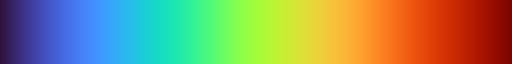

In [36]:
cm.turbo

In [37]:
for name, deriv in zip(["pre", "post"], derivlist):
    deriv_data = np.nanmean(deriv.get_data(), axis=0).round(3)
    deriv_summ = dict(zip(deriv.ch_names, deriv_data))
    max_in_deriv = np.nanmax(deriv.get_data())
    print("Max in colorbar is: ", max_in_deriv)
    print(np.max(deriv_data))

#     fname = f"./{subject}-fragilitysummary-{name}.json"
#     with open(fname, "w") as fout:
#         json.dump(deriv_summ, fout)

Max in colorbar is:  0.7343227625690432
0.435
Max in colorbar is:  0.49013314808307423
0.218


# Plot final heatmap

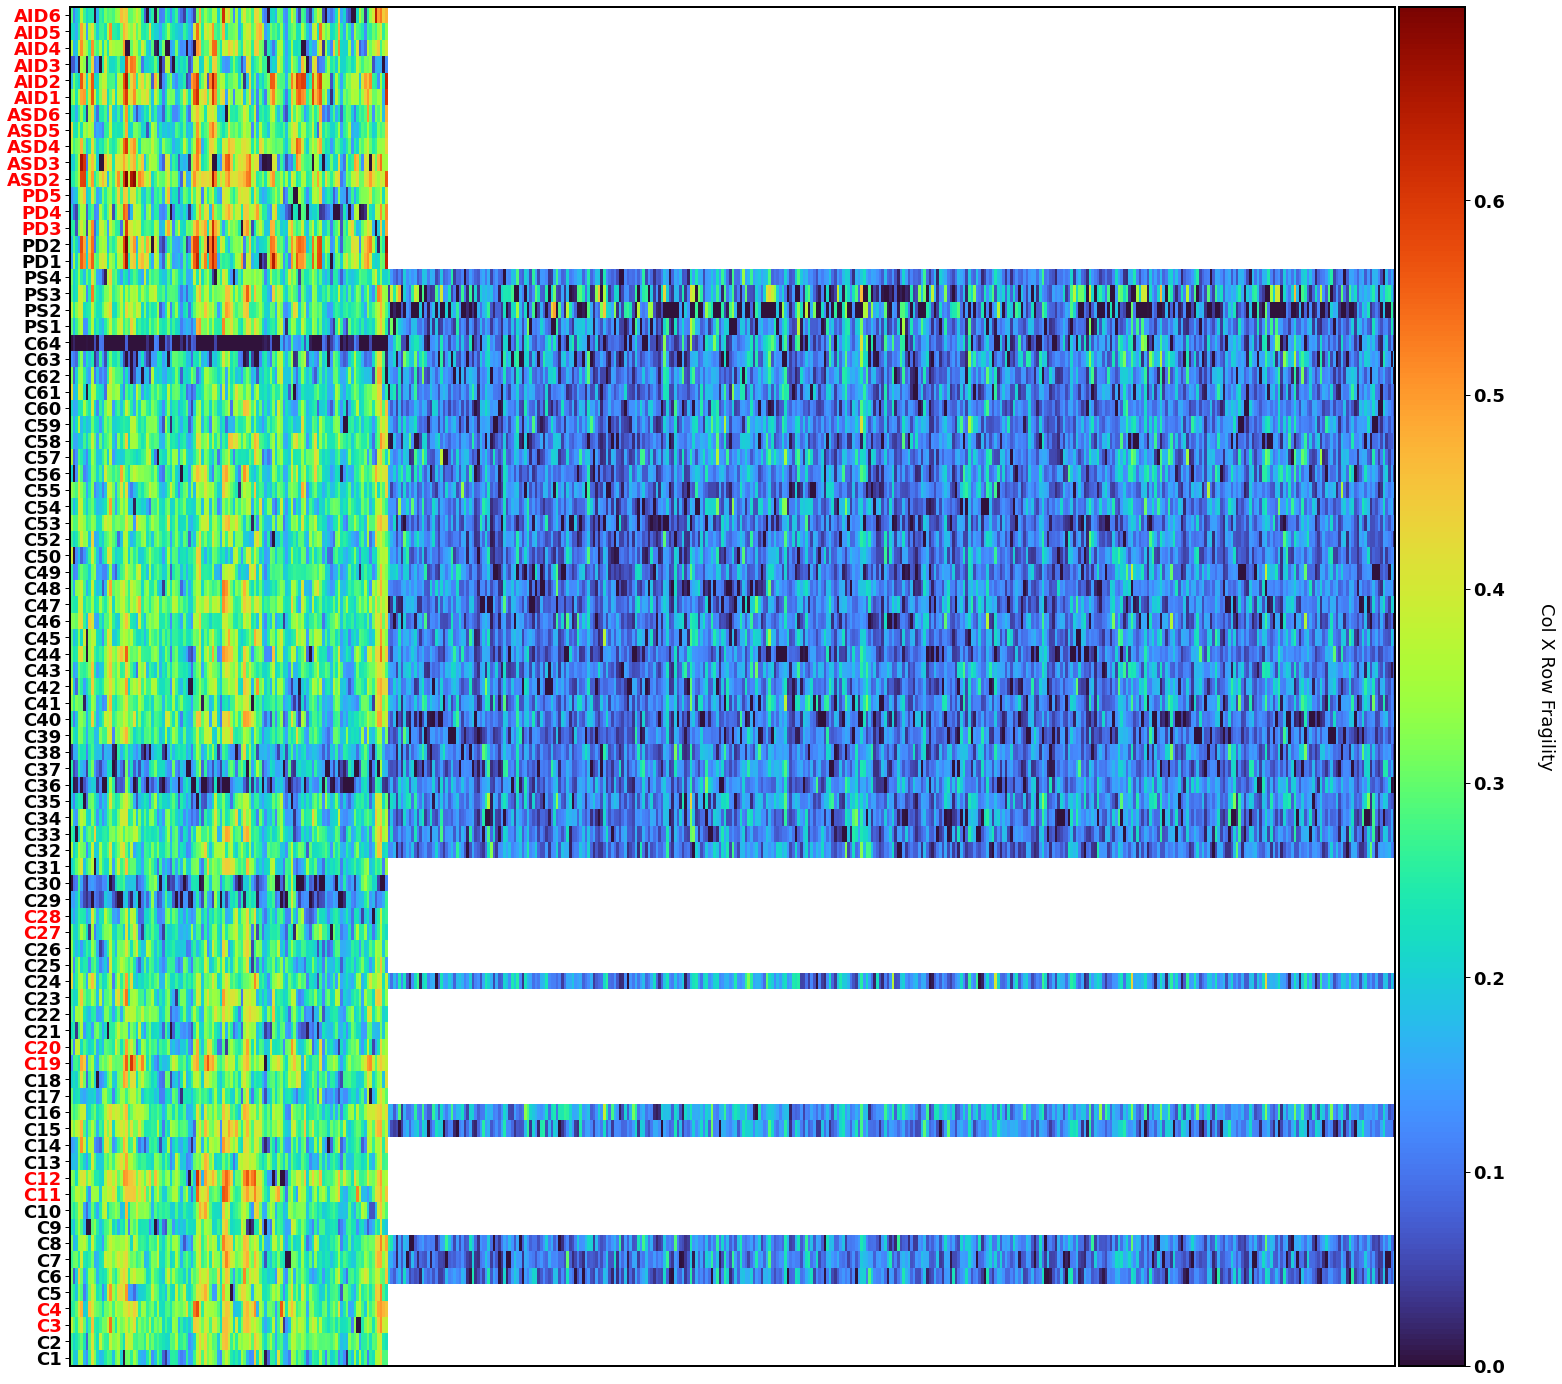

In [38]:
sns.set_context("paper", font_scale=1.4)
title = (
    f"{subject} Fragility Over All Sessions \n (White space = disconnected/resected)"
)
fig, ax = derivative.plot_heatmap(
    #     norm=mpl.colors.LogNorm(vmin=0., vmax=1),
    #         vmin=0, vmax=0.6,
    #     vmax=np.nanmax(derivlist[0].get_data()),
    #     vmax=np.nanquantile(derivative.get_data().flatten(), 0.99),
    #     cmap="viridis",
    #     vmin=-3, vmax=3,|
    #     norm=mpl.colors.PowerNorm(gamma=0.5),
    #     title=title,
    soz_chs=resected_chs,
    cbarlabel=cbarlabel,
    xticks=None,
    xlabel=None
    #     set_col_under=False,
    #     log_scale=True,
)
sns.set_context("paper", font_scale=2.0)

colors = {
    "extraoperative": "black",
    "preresection": "white",
    "intraresection": "gray",
    "postresection": "brown",
}

# for onset, description in zip(onsets, descriptions):
#     session = description.split("-")[1]
#     color = colors[session]
#     ax.axvline(onset, label=description, lw=5, color=color)

# pprint(descriptions)

fig.savefig(
    figures_path
    / f"sub-{subject}_{derivtype}_{reference}_{sampling_res}_threshold-{threshold}_baseline-{baseline}_filteroutliers{detect_outliers}.pdf",
    bbox_inches="tight",
)